In [4]:
import math
import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib import rc
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import LinearLocator
from tqdm import tqdm
import scipy
from scipy.integrate import odeint, DOP853, solve_ivp
from scipy.stats import linregress
from scipy.stats import special_ortho_group
from sklearn.metrics import mean_absolute_error
from itertools import chain, combinations, permutations
import seaborn as sns


import os, sys
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 
sys.path.insert(0, parentdir) 
sys.path.insert(0, currentdir + "\Code") 
"""cmap = 'gray'
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)"""

ModuleNotFoundError: No module named 'tqdm'

In [8]:
# symmetric cosine weight matrix W sym jk = JI + JE cos(theta_j - theta_K)
# where JE and JI respectively control the strength of the tuned and untuned components of recurrent connectivity between neurons with preferred headings theta_j and theta_k.

# For a network of size N , there are N 3 such “optimal” values of local excitation J*E

# The parameters (JI, JE) can be set such that this system will generate a population profile that qualitatively looks like a discretely sampled “bump” of activity.
# (JI, JE) are within the subset  \Omega = \OmegaJI\times\OmegaJE \subset (−1, 1) \times (2,1)

def get_corners(N, m):
    #works for even N
    corners = []
    corner_0 = np.array([m]*N)
    corner_0[int(N/2):] *= -1
    corner_0[int(N/2)-int(N/4):int(N/2)] = 0
    corner_0[N-int(N/4):] = 0
    for support_j in range(N):
        corners.append(np.roll(corner_0, support_j))
    corners = np.array(corners)
    return corners

def get_bumps_along_oneside_ring(N, m, corners, step_size=0.1):
    x = np.arange(0, m+step_size, step_size)
    n_xs = x.shape[0]
    bumps = np.zeros((N, n_xs))
    for i, x_i in enumerate(x):
        for j in range(N):
            bumps[j,i] = np.interp(x_i, [0,m], [corners[0][j],corners[1][j]])
    return bumps

def get_all_bumps(N, bumps):
    all_bumps = []
    for support_j in range(N):
        for bump_i in range(bumps.shape[1]):
            all_bumps.append(np.roll(bumps[:,bump_i], support_j))
    all_bumps = np.array(all_bumps)
    return all_bumps

def get_all_bumps_2darray(N, bumps):
    all_bumps = np.zeros((N,bumps.shape[1],N))
    for support_j in range(N):
        for bump_i in range(bumps.shape[1]):
            all_bumps[support_j,bump_i] = np.roll(bumps[:,bump_i], support_j)
    return all_bumps

def get_noorman_symmetric_weights(N, J_I = 1, J_E = 1):
    # W sym jk = JI + JE cos(theta_j - theta_K)
    x = np.arange(0,N,1)
    row = J_I + J_E*np.cos(2*np.pi*x/N)
    W = scipy.linalg.circulant(row)
    return W


# W asym jk =sin(theta_j - theta_k)
def get_noorman_asymmetric_weights(N):
    # W asym jk =sin(theta_j - theta_k)
    x = np.arange(0,N,1)
    row = np.sin(2*np.pi*x/N)
    W = scipy.linalg.circulant(row)
    return W

def noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,v_in):
    """Differential equation of head direction network in Noorman et al., 2022. 
    tau: integration constant
    transfer_function: each neuron transforms its inputs via a nonlinear transfer function
    W_sym, W_asym: symmetric and asymmetric weight matrices
    v_in: input
    c_ff: a constant feedforward input to all neurons in the network
    N: number of neurons in the network
    """

    return (-x + np.dot(W_sym+v_in*W_asym, transfer_function(x))/N + c_ff)/tau

def noorman_ode_with_noise(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,noises,v_in):
    """Differential equation of head direction network in Noorman et al., 2022. 
    tau: integration constant
    transfer_function: each neuron transforms its inputs via a nonlinear transfer function
    W_sym, W_asym: symmetric and asymmetric weight matrices
    v_in: input
    c_ff: a constant feedforward input to all neurons in the network
    N: number of neurons in the network
    """
    if noises is not None:
        return (-x + np.dot(W_sym+v_in*W_asym, transfer_function(x))/N + c_ff + noises[round(t)])/tau
    else:
        return (-x + np.dot(W_sym+v_in*W_asym, transfer_function(x))/N + c_ff)/tau

#Bump perturbations
def noorman_ode_pert(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,center,rotation_mat,amplitude,b):
    """
    create ODE for Noorman ring attractor with a local bump perturbation
    center,rotation_mat,amplitude,b are set
    """
    vector_bump = bump_perturbation(x, center, rotation_mat, amplitude, b)
    noor = noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
    return noor + vector_bump

def noorman_ode_Npert(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,Nbumps):
    """
    create ODE for Noorman ring attractor with Nbumps local bump perturbations
    for each bump: center,rotation_mat,amplitude,b are random
    """
    noorode = noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
    for bi in range(Nbumps):
        bump_i = np.random.randint(bumps.shape[0]) 
        roll_j = np.random.randint(N)
        center = np.roll(bumps[:,bump_i], roll_j).copy()
        rotation_mat = special_ortho_group.rvs(N)
        amplitude = np.random.rand()
        b = np.random.rand()
        noorode += bump_perturbation(x, center, rotation_mat, amplitude, b)

    return noorode

# Fixed points and their stabilities
def noorman_jacobian(x, W_sym):
    N = W_sym.shape[0]
    
    r = np.where(x>0)
    W_sub = np.zeros((N,N))
    W_sub[:,r] = W_sym[:,r]
    J = -np.eye(N)
    J += W_sub/N
    return J

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def noorman_fixed_points(W_sym, c_ff):
    """
    Takes as argument all the parameters of the recurrent part of the model (W_sym, c_ff)
    \dot x = -x + 1/N W_sym ReLU(x) + c_ff = 0
    """
    fixed_point_list = []

    N = W_sym.shape[0]
    subsets = powerset(range(N))
    for support in subsets:
        if support == ():
            continue
        r = np.array(support)
        
        W_sub = np.zeros((N,N))
        W_sub[:,r] = W_sym[:,r]
        A = W_sub/N - np.eye(N)
        fixed_point = -np.dot(np.linalg.inv(A), np.ones(N)*c_ff)
        
        #check true fixed point
        negativity_condition = True
        # print(r, [item for item in range(N) if item not in r])
        for i in r:
            if fixed_point[i] <= 0:
                negativity_condition = False
        for i in [item for item in range(N) if item not in r]:
            if fixed_point[i] >= 0:
                negativity_condition = False
        
        if negativity_condition:
            fixed_point_list.append(fixed_point)
        
    fixed_point_array = np.array(fixed_point_list)
    return fixed_point_array




def bump_perturbation(x, center, rotation_mat, amplitude, b=1):
    """
    Perturbation is composed of parallel vector field 
    with the location given by center, 
    the norm of the vectors determined by a bump function
    and the orientation given by theta
    
    x.shape = (Numberofpoints,N)
    rotation_mat: orientation of perturbation
    implemented for N-dimensional systems
    """
    N = x.shape[0]
    vector_bump = np.zeros(N)
    vector_bump[0] = 1.
    rotation_mat = special_ortho_group.rvs(N)
    vector_bump = np.dot(vector_bump, rotation_mat)
    vector_bump = np.multiply(vector_bump, bump_function(x, center=center, amplitude=amplitude, b=b))
    
    return vector_bump

# we will take phi(·) to be threshold linear
def get_state_noise(norm, corners_max, N, t):
    eps = np.random.uniform(-1, 1, (len(t) + 1, N))
    eps /= np.linalg.norm(eps)
    eps *= norm * corners_max / 100  # define norm as percentage of maximum activity
    return eps

def get_weight_perturbation(norm, W_sym_max, N):
    eps = np.random.uniform(-1, 1, (N, N))
    eps /= np.linalg.norm(eps)
    eps *= norm * W_sym_max / 100  # perturbation norm as percentage of maximum neural activity
    return eps

def v_in(t):
    return 0

def ReLU(x):
    return np.where(x<0,0,x)

def get_angle_from_activity(N,activity):
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)  # Neuron preferred angles
    # Compute current bump angle using center of mass
    x_com = np.sum(np.cos(angles) * activity)
    y_com = np.sum(np.sin(angles) * activity)
    current_angle = np.arctan2(y_com, x_com)
    return current_angle / np.pi * 180

def get_sol(init,v_in,maxT,weight_norm,state_norm,W_sym,W_asym):
    t = np.linspace(0, maxT, 501)
    weight_pert = get_weight_perturbation(weight_norm, np.abs(W_sym).max(), N)
    noises = get_state_noise(state_norm, init, N, t)
    
    sol = solve_ivp(noorman_ode_with_noise, y0=init,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym+weight_pert, W_asym, c_ff, N, noises, v_in]),dense_output=True)

    # sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
    # fig, axs = plt.subplots(1, 1, figsize=(15, 8), sharex=True, sharey=True)
    # axs.imshow(sol.sol(t))
    # axs.set_xlabel("Time")
    # axs.set_ylabel("Neurons")

    return sol.sol(t[-1])

# find angle of bump shift when v_in=1
def find_v2angle_mapping(init,v_in,maxT,weight_norm,state_norm,W_sym,W_asym):
    t = np.linspace(0, maxT, 501)
    weight_pert = get_weight_perturbation(weight_norm, np.abs(W_sym).max(), N)
    noises = get_state_noise(state_norm, init, N, t)

    sol = solve_ivp(noorman_ode_with_noise, y0=init,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym+weight_pert, W_asym, c_ff, N, noises, v_in]),dense_output=True)
    new_angle, old_angle = get_angle_from_activity(N,sol.sol(t[-1])), get_angle_from_activity(N,init)
    new_angle, old_angle = new_angle % 360, old_angle % 360
    return new_angle

def get_angle_diff(angle1,angle2):
    diff = np.abs(angle2-angle1)
    return min(diff,360-diff)

def deviation_from_linear(x, y):
    slope, intercept, _, _, _ = linregress(x, y)
    y_pred = slope * x + intercept  # Valorile pe dreaptă
    residuals = y - y_pred  # Diferența față de punctele reale
    return residuals

def get_attractor_vin_slope(init_activity,test_v_in,weight_norm,state_norm,maxT):
    
    m = np.max(init_activity) # m #round? what should the maximum be according to the paper?
    corners = get_corners(N, m)
    bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=0.05)
    step_size = .1
    x = np.arange(0, m+step_size, step_size)
    all_bumps = get_all_bumps(N, bumps)

    slopes = []
    for activity in all_bumps:
        # Calculate necessary v_in to shift by 10 degrees
        angle0 = find_v2angle_mapping(activity,0,maxT,weight_norm,state_norm)
        angle = find_v2angle_mapping(activity,test_v_in,maxT,weight_norm,state_norm)
        slope = get_angle_diff(angle, angle0) / (test_v_in - 0)
        slopes.append(slope)
    return np.median(np.array(slopes))

## Parameters

In [9]:
tau = 0.1
transfer_function = ReLU
N = 6
c_ff = 1.

weight_norms = [1,3,5,10]
state_norms = [1,3,5,10]
JEs = 4 + np.array([-10,-5,-3,-1,1,3,5,10]) / 100 * 4
JIs = -2.4 + np.array([-10,-5,-3,-1,1,3,5,10]) / 100 * 2.4

### Check if increasing v_in linearly increases the angle shift linearly. When the angle by which to shift the bump needs to be larger or smaller, just adjust v_in assuming a linear relationship between v_in and the angle shift. Results here confirm that a linear relationship is an assumption that can be made.

### Analyze dependency of (v_in, angle shift) linearity on the perturbation parameters

In [ ]:
def get_average_residuals(J_E,J_I,weight_norm,state_norm):
    np.random.seed(7)

    W_sym = get_noorman_symmetric_weights(N, J_I, J_E)
    W_asym = get_noorman_asymmetric_weights(N)
        
    # Initialize attractor
    init = np.random.uniform(0,1,N)
    init_maxT = 50
    init_weight_norm,init_state_norm = 0,0
    activity = get_sol(init,0,init_maxT,init_weight_norm,init_state_norm,W_sym,W_asym)

    m = np.max(activity) # m #round? what should the maximum be according to the paper?
    corners = get_corners(N, m)
    bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=0.05)
    all_bumps = get_all_bumps(N, bumps)

    maes = []
    for activity in all_bumps:        
        maxT = 0.01
        test_v_ins = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
        angles = []
        for test_v_in in test_v_ins:
            try:
                angle = find_v2angle_mapping(activity,test_v_in,maxT,weight_norm,state_norm,W_sym,W_asym)
            except:
                angle = None
            angles.append(angle)
        if None in angles:
            maes.append(None)
        else:
            angles = np.array(angles)
            residuals = deviation_from_linear(test_v_ins,angles)
            mae = mean_absolute_error(np.zeros_like(residuals), residuals)
            maes.append(mae)
    if None in maes:
        return 0
    else:
        maes = np.array(maes)
        return np.mean(maes)

def get_all_residuals(JEs,JIs,weight_norms,state_norms):
    all_average_residual_maes = {}
    for JE in JEs:
        for JI in JIs:
            for weight_norm in weight_norms:
                for state_norm in state_norms:
                    comb = (JE,JI,weight_norm,state_norm)
                    print(JE,JI,weight_norm,state_norm)
                    average_residual_mae_per_comb = get_average_residuals(JE,JI,weight_norm,state_norm)
                    if average_residual_mae_per_comb == 0:
                        continue
                    else:
                        all_average_residual_maes[comb] = average_residual_mae_per_comb
    return all_average_residual_maes # np.array(all_average_residual_maes).reshape(len(JEs),len(JIs),len(weight_norms),len(state_norms))


In [48]:
all_residuals = get_all_residuals(JEs,JIs,weight_norms,state_norms)
import pickle
with open("results//all_JE_JI//v_in_residuals.pkl", "wb") as f:
    pickle.dump(all_residuals, f)
    

3.6 -2.6399999999999997 1 1
3.6 -2.6399999999999997 1 3
3.6 -2.6399999999999997 1 5
3.6 -2.6399999999999997 1 10
3.6 -2.6399999999999997 3 1
3.6 -2.6399999999999997 3 3
3.6 -2.6399999999999997 3 5
3.6 -2.6399999999999997 3 10
3.6 -2.6399999999999997 5 1
3.6 -2.6399999999999997 5 3
3.6 -2.6399999999999997 5 5
3.6 -2.6399999999999997 5 10
3.6 -2.6399999999999997 10 1
3.6 -2.6399999999999997 10 3
3.6 -2.6399999999999997 10 5
3.6 -2.6399999999999997 10 10
3.6 -2.52 1 1
3.6 -2.52 1 3
3.6 -2.52 1 5
3.6 -2.52 1 10
3.6 -2.52 3 1
3.6 -2.52 3 3
3.6 -2.52 3 5
3.6 -2.52 3 10
3.6 -2.52 5 1
3.6 -2.52 5 3
3.6 -2.52 5 5
3.6 -2.52 5 10
3.6 -2.52 10 1
3.6 -2.52 10 3
3.6 -2.52 10 5
3.6 -2.52 10 10
3.6 -2.472 1 1
3.6 -2.472 1 3
3.6 -2.472 1 5
3.6 -2.472 1 10
3.6 -2.472 3 1
3.6 -2.472 3 3
3.6 -2.472 3 5
3.6 -2.472 3 10
3.6 -2.472 5 1
3.6 -2.472 5 3
3.6 -2.472 5 5
3.6 -2.472 5 10
3.6 -2.472 10 1
3.6 -2.472 10 3
3.6 -2.472 10 5
3.6 -2.472 10 10
3.6 -2.424 1 1
3.6 -2.424 1 3
3.6 -2.424 1 5
3.6 -2.424 1 10
3.6

Mean residual =  0.29565246628204345


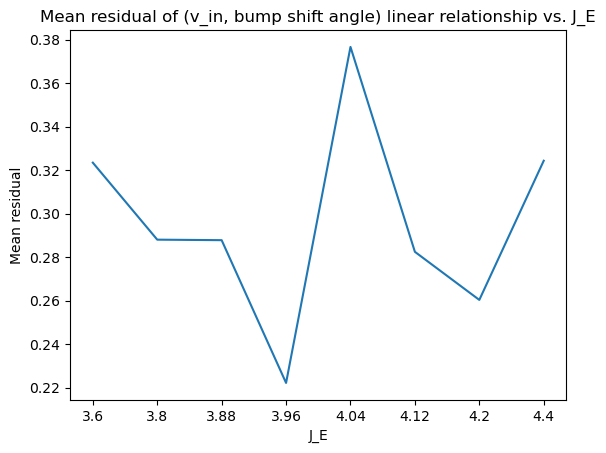

In [16]:
import pickle
with open("D:\\projects\\Attractor_based_memory_for_path_integration\\results\\short-term\\processed_result\\v_in_residuals.pkl", "rb") as f:
    all_residuals = pickle.load(f)
    
all_res=[]
for J_E in JEs:
    res_per_element = []
    for comb in all_residuals:
        comb = list(comb)
        comb[0] = J_E
        comb = tuple(comb)
        if comb in list(all_residuals.keys()):
            res_per_element.append(all_residuals[comb])
    all_res.append(np.mean(np.array(res_per_element)))

plt.plot(all_res)
plt.xlabel('J_E')
plt.xticks(range(len(JEs)),JEs)
plt.ylabel('Mean residual')
plt.title('Mean residual of (v_in, bump shift angle) linear relationship vs. J_E')
plt.savefig('results/short-term/graphs/v_in_residuals_vs_JE.png')

print('Mean residual = ',np.mean(np.array(all_res)))

Mean residual =  0.2956524662820435


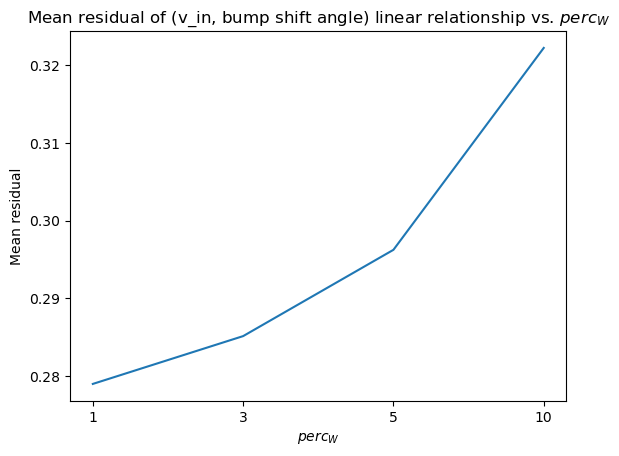

In [15]:
import pickle
with open("D:\\projects\\Attractor_based_memory_for_path_integration\\results\\short-term\\processed_result\\v_in_residuals.pkl", "rb") as f:
    all_residuals = pickle.load(f)
    
all_res=[]
for weight_norm in weight_norms:
    res_per_element = []
    for comb in all_residuals:
        comb = list(comb)
        comb[2] = weight_norm
        comb = tuple(comb)
        if comb in list(all_residuals.keys()):
            res_per_element.append(all_residuals[comb])
    all_res.append(np.mean(np.array(res_per_element)))

plt.plot(all_res)
plt.xlabel('$perc_W$')
plt.xticks(range(len(weight_norms)),weight_norms)
plt.ylabel('Mean residual')
plt.title('Mean residual of (v_in, bump shift angle) linear relationship vs. $perc_W$')
plt.savefig('results/short-term/graphs/v_in_residuals_vs_weight_norm.png')

print('Mean residual = ',np.mean(np.array(all_res)))

### Check how much the slope differs between places on the ring. Because the attractor is approximately continuous, the slope of the linear v_in <-> bump angle shift relationship is different at different ring locations, but in the code we will only use the average slope. Check how much the slopes differ and what error taking the average introduces. The error is small enough such that it won't affect the path integration performance much. 

In [52]:
def get_average_slope(J_E,J_I,weight_norm,state_norm):
    np.random.seed(7)
        
    # Initialize attractor
    init = np.random.uniform(0,1,N)
    init_maxT = 50
    init_weight_norm,init_state_norm = 0,0

    W_sym = get_noorman_symmetric_weights(N, J_I, J_E)
    W_asym = get_noorman_asymmetric_weights(N)

    activity = get_sol(init,0,init_maxT,init_weight_norm,init_state_norm,W_sym,W_asym)
    m = np.max(activity) # m #round? what should the maximum be according to the paper?
    corners = get_corners(N, m)
    bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=0.05)
    all_bumps = get_all_bumps(N, bumps)

    slopes = []
    for activity in all_bumps:
        # Calculate necessary v_in to shift by 10 degrees
        maxT = 0.01
        test_v_in = 0.1
        angle0 = find_v2angle_mapping(activity,0,maxT,weight_norm,state_norm,W_sym,W_asym)
        angle = find_v2angle_mapping(activity,test_v_in,maxT,weight_norm,state_norm,W_sym,W_asym)
        slope = get_angle_diff(angle, angle0) / (test_v_in - 0)
        slopes.append(slope)
    slopes = np.array(slopes)
    return np.std(slopes) / np.mean(slopes) * 100

def get_all_slopes(JEs,JIs,weight_norms,state_norms):
    all_average_slopes = {}
    for JE in JEs:
        for JI in JIs:
            for weight_norm in weight_norms:
                for state_norm in state_norms:
                    comb = (JE,JI,weight_norm,state_norm)
                    print(JE,JI,weight_norm,state_norm)
                    average_slope = get_average_slope(JE,JI,weight_norm,state_norm)
                    all_average_slopes[comb] = average_slope
    return all_average_slopes #np.array(all_average_slopes).reshape(len(JEs),len(JIs),len(weight_norms),len(state_norms))

In [53]:
all_slopes = get_all_slopes(JEs,JIs,weight_norms,state_norms)
with open("results//all_JE_JI//v_in_std.pkl", "wb") as f:
    pickle.dump(all_slopes, f)

3.6 -2.6399999999999997 1 1
3.6 -2.6399999999999997 1 3
3.6 -2.6399999999999997 1 5
3.6 -2.6399999999999997 1 10
3.6 -2.6399999999999997 3 1
3.6 -2.6399999999999997 3 3
3.6 -2.6399999999999997 3 5
3.6 -2.6399999999999997 3 10
3.6 -2.6399999999999997 5 1
3.6 -2.6399999999999997 5 3
3.6 -2.6399999999999997 5 5
3.6 -2.6399999999999997 5 10
3.6 -2.6399999999999997 10 1
3.6 -2.6399999999999997 10 3
3.6 -2.6399999999999997 10 5
3.6 -2.6399999999999997 10 10
3.6 -2.52 1 1
3.6 -2.52 1 3
3.6 -2.52 1 5
3.6 -2.52 1 10
3.6 -2.52 3 1
3.6 -2.52 3 3
3.6 -2.52 3 5
3.6 -2.52 3 10
3.6 -2.52 5 1
3.6 -2.52 5 3
3.6 -2.52 5 5
3.6 -2.52 5 10
3.6 -2.52 10 1
3.6 -2.52 10 3
3.6 -2.52 10 5
3.6 -2.52 10 10
3.6 -2.472 1 1
3.6 -2.472 1 3
3.6 -2.472 1 5
3.6 -2.472 1 10
3.6 -2.472 3 1
3.6 -2.472 3 3
3.6 -2.472 3 5
3.6 -2.472 3 10
3.6 -2.472 5 1
3.6 -2.472 5 3
3.6 -2.472 5 5
3.6 -2.472 5 10
3.6 -2.472 10 1
3.6 -2.472 10 3
3.6 -2.472 10 5
3.6 -2.472 10 10
3.6 -2.424 1 1
3.6 -2.424 1 3
3.6 -2.424 1 5
3.6 -2.424 1 10
3.6

Mean slope std/mean =  30.52151113330418


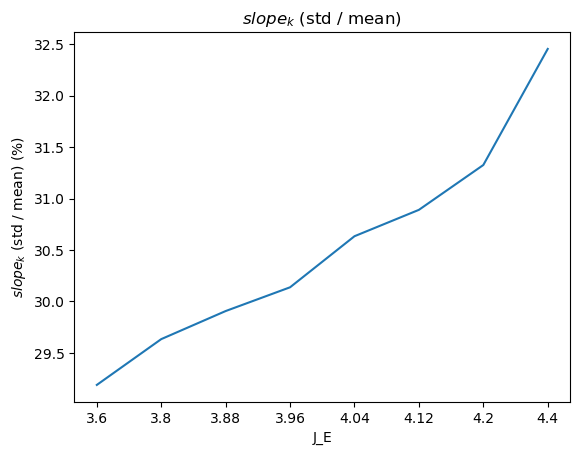

In [12]:
import pickle
with open("D:\\projects\\Attractor_based_memory_for_path_integration\\results\\short-term\\processed_result\\v_in_std.pkl", "rb") as f:
    all_slopes = pickle.load(f)
    
all_res=[]
for J_E in JEs:
    res_per_element = []
    for comb in all_slopes:
        comb = list(comb)
        comb[0] = J_E
        comb = tuple(comb)
        if comb in list(all_slopes.keys()):
            res_per_element.append(all_slopes[comb])
    all_res.append(np.mean(np.array(res_per_element)))
    
plt.plot(all_res)
plt.title(r'$slope_k$ (std / mean)')
plt.xlabel('J_E')
plt.xticks(range(len(JEs)),JEs)
plt.ylabel(r'$slope_k$ (std / mean) (%)')
plt.savefig('results/short-term/graphs/v_in_std_vs_JE.png')

print('Mean slope std/mean = ',np.mean(np.array(all_res)))